# Theta-based Summary Statistics
## Site Frequency Spectrum
### Inferring Ancestral alleles
It is important to have the ancestral state for some of the analyses below. To this end, we used short reads sequenced by the [B10K](https://b10k.genomics.cn/species.html) consortium and stored by the China National GeneBank DataBase (CNGBdb) for large-bill tern ([*Phaetusa simplex*](https://db.cngb.org/search/organism/297813/) NCBI ID: 297813, CNGB Sample ID: CNS0103161, CNGB Experiment ID: CNX0082959) and black skimmer ([*Rhynchops niger*](https://db.cngb.org/search/organism/227184/) NCBI ID: 227184, CNGB Sample ID: CNS0103105, CNGB Experiment ID: CNX0082867 - CNX0082869) to polarise the site frequency spectrum for fairy terns. Whereas resequence data generated by [Galla et al 2019](https://doi.org/10.3390/genes10010009) for the avocet (*Recurvirostra avosetta*) and pied stilt (*Himantopus himantopus*) were used to polarise kakī. This ([brief discussion](https://www.biostars.org/p/298013/)) outlines the benefit of using this approach for ANGSD-base analyses. The reads for each of the outgroups were trimmed, aligned, and duplicates marked in the same manner as the fairy tern and kakī population short-reads.  

In [ ]:
# sra-tools blah blah
# Alignment
# Dup removal
# Downsampling

In [ ]:
angsd -P 16 -doFasta 2 -doCounts 1 -out ${ANGSD}tern_ancestral -i ${DIR}merged_tern_markdup_autosomes.bam
angsd -P 16 -doFasta 2 -doCounts 1 -out ${ANGSD}stilt_ancestral -i ${DIR}merged_stilt_markdup_autosomes.bam
angsd -P 16 -doFasta 2 -doCounts 1 -out ${ANGSD}pied_alleles -b pied.list
angsd -P 16 -doFasta 2 -doCounts 1 -out ${ANGSD}AFT_alleles -b AU.list

### SFS Estimation
We then estimated the SFS using ANGSD and realSFS.

In [ ]:
for TOOL in samtools neutral
    do
    printf "STARTED RUNNING ANGSD FOR $TOOL DATA SET AT "
    date
    if [[ "$TOOL" == "samtools" ]]
        then
        angsd -P 16 -b ${ANGSD}AU.list -ref $TREF -anc $TANC -out ${ANGSD}samtools/sfs/AU \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 19 -setMinDepth 200 -setMaxDepth 420 -doCounts 1 \
            -GL 1 -doSaf 1
        angsd -P 16 -b ${ANGSD}TI.list -ref $TREF -anc $TANC -out ${ANGSD}samtools/sfs/TI \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ20 -minInd 15 -setMinDepth 120 -setMaxDepth 280 -doCounts 1 \
            -GL 1 -doSaf 1
        angsd -P 16 -b ${ANGSD}KI.list -ref $KREF -anc $KANC -out ${ANGSD}samtools/sfs/KI \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ20 -minInd 15 -setMinDepth 700 -setMaxDepth 1200 -doCounts 1 \
            -GL 1 -doSaf 1
    else
        angsd -P 16 -b ${ANGSD}AU.list -ref $TREF -anc $TANC -sites $TSITES -out ${ANGSD}neutral/sfs/AU \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 19 -setMinDepth 200 -setMaxDepth 420 -doCounts 1 \
            -GL 1 -doSaf 1
        angsd -P 16 -b ${ANGSD}TI.list -ref $TREF -anc $TANC -sites $TSITES -out ${ANGSD}neutral/sfs/TI \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ20 -minInd 15 -setMinDepth 120 -setMaxDepth 280 -doCounts 1 \
            -GL 1 -doSaf 1
        angsd -P 16 -b ${ANGSD}KI.list -ref $KREF -anc $KANC -sites $KSITES -out ${ANGSD}neutral/sfs/KI \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ20 -minInd 15 -setMinDepth 700 -setMaxDepth 1200 -doCounts 1 \
            -GL 1 -doSaf 1
    fi
done

Then `realSFS` was run to estimate the site frequency spectrum and theta-based statistics.  

In [ ]:
realSFS -P 40 -anc ${TANC} -ref ${TREF} ${ANGSD}${TOOL}/sfs/AU.saf.idx > ${ANGSD}${TOOL}/sfs/AU.sfs
realSFS -P 40 -anc ${TANC} -ref ${TREF} ${ANGSD}${TOOL}/sfs/TI.saf.idx > ${ANGSD}${TOOL}/sfs/TI.sfs
realSFS -P 40 -anc ${KANC} -ref ${KREF} ${ANGSD}${TOOL}sfs/KI.saf.idx > ${ANGSD}${TOOL}sfs/KI.sfs
realSFS -P 40 -anc ${TANC} -ref ${TREF} ${ANGSD}${TOOL}/sfs/AU.saf.idx ${ANGSD}${TOOL}/sfs/TI.saf.idx > ${ANGSD}${TOOL}/sfs/GLOBAL.sfs

## Population Structure
### Estimating Population Differentiation (SNP-based Watterson's Theta)
Here we estimate Theta (F<sub>ST</sub>) between Australian fairy tern populations in Western Australia and tara iti. To do so, we leverage the site frequency spectrum (SFS) generated above.  

In [ ]:
realSFS fst index ${DIR}${TOOL}/sfs/AU.saf.idx ${DIR}${TOOL}/sfs/TI.saf.idx -sfs ${DIR}${TOOL}/sfs/GLOBAL.sfs -fstout ${DIR}${TOOL}/sfs/GLOBAL -whichFst 1
realSFS fst stats2 ${DIR}${TOOL}/sfs/GLOBAL.fst.idx \
    -tole 1e-6 -ref ${TREF} -anc ${TANC} \
    -win 10000 -step 1000 > ${DIR}${TOOL}/sfs/GLOBAL_stat2_10KBwindow_1KBstep.tsv

realSFS fst stats2 ${DIR}${TOOL}/sfs/GLOBAL.fst.idx \
    -tole 1e-6 -ref ${TREF} -anc ${TANC} \
    -win 50000 -step 10000 > ${DIR}${TOOL}/sfs/GLOBAL_stat2_50KBwindow_10KBstep.tsv

realSFS fst stats ${DIR}${TOOL}/sfs/GLOBAL.fst.idx \
    -tole 1e-6 -ref ${TREF} -anc $ANC \
    -win 50000 -step 10000 -whichFst 1 > ${ANGSD}${TOOL}sfs/GLOBAL_stat1_50KBwindow_10KBstep.tsv

The final command estimated a global weighted and unweighted F<sub>ST</sub> of `0.001981` and `0.838787` respectively for 259,924,909 putatively neutral sites and an unweighted F<sub>ST</sub> of `0.001987` and weighted F<sub>ST</sub> of `0.836593` for all 507,424,045 sites.  

In [33]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

path = '/nesi/nobackup/uc03718/'
os.chdir(path)
print(os.getcwd())

/nesi/nobackup/uc03718


In [ ]:
fst = pd.read_csv('angsd/samtools/sfs/GLOBAL_whole-genome_stat2_50KBwindow_10KBstep.tsv', sep='\t', usecols=['chr', 'midPos', 'Nsites', 'FST'])

fst['x'] = range(len(fst))

plt.figure(figsize=(20,5))
palette=['grey', 'black']
ax=sns.scatterplot(data=fst, x='x', y='FST', hue='chr', palette=palette, alpha=0.5, s=3, legend=False)

ax.set_title('A)', fontsize=20, loc='left')
ax.set_xlabel('Chromosome', fontsize=20)
ax.set_ylabel('$F_{ST}$', fontsize=18)
ax.set_xlim(0, 108800)
ax.set_ylim(0, 1)
ax.set_xticks([])

plt.savefig('plots/whole-genome_Fst_allChr.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_68097/3059963799.py:7: UserWarning: 
The palette list has fewer values (2) than needed (22) and will cycle, which may produce an uninterpretable plot.
  ax=sns.scatterplot(data=neutralfst, x='x', y='FST', hue='chr', palette=palette, alpha=0.5, s=3, legend=False)


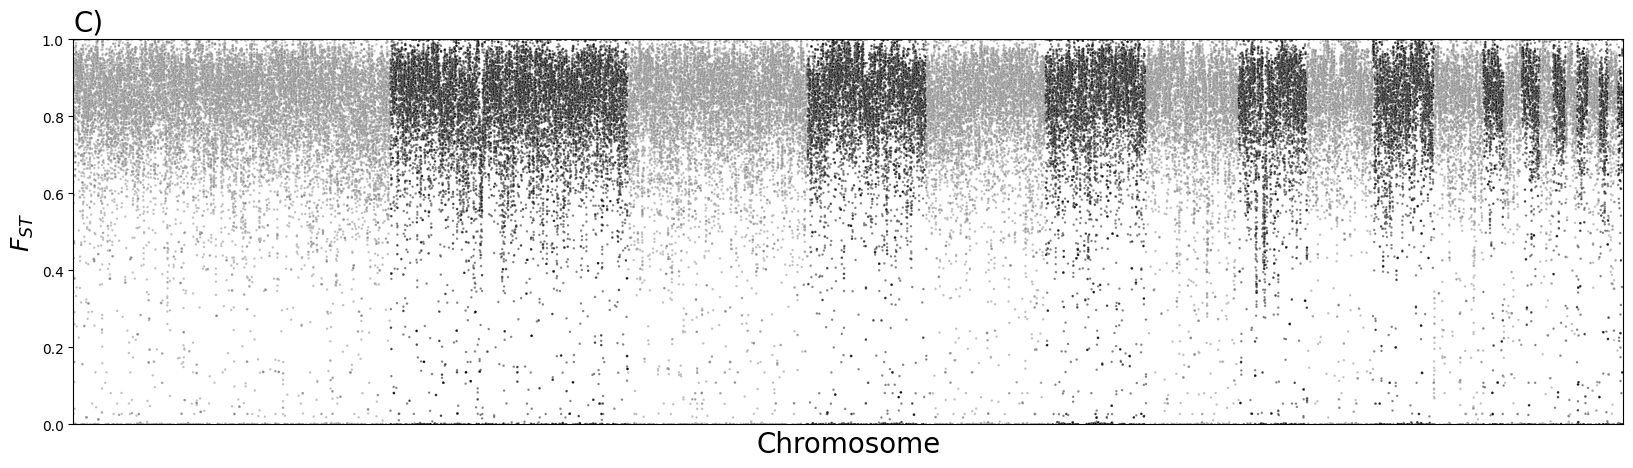

In [35]:
neutralfst = pd.read_csv('angsd/neutral/sfs/GLOBAL_stat2_50KBwindow_10KBstep.tsv', sep='\t', usecols=['chr', 'midPos', 'Nsites', 'FST'])

neutralfst['x'] = range(len(neutralfst))

plt.figure(figsize=(20,5))
palette=['grey', 'black']
ax=sns.scatterplot(data=neutralfst, x='x', y='FST', hue='chr', palette=palette, alpha=0.5, s=3, legend=False)

ax.set_title('C)', fontsize=20, loc='left')
ax.set_xlabel('Chromosome', fontsize=20)
ax.set_ylabel('$F_{ST}$', fontsize=18)
ax.set_xlim(0, 101500)
ax.set_ylim(0, 1)
ax.set_xticks([])

plt.savefig('TI_ms_plots/neutral_Fst_allChr.png', dpi=300, bbox_inches='tight')

In [ ]:
chr1fst = neutralfst[(neutralfst['chr']=='CM020437.1_RagTag')]

chr1fst['x'] = range(len(chr1fst))

plt.figure(figsize=(14,7))
palette=['black', 'grey']
ax=sns.scatterplot(data=chr1fst, x='x', y='FST', color='black', alpha=0.5, s=3, legend=False)

ax.set_xlabel('Chromosome Position', fontsize=14)
ax.set_ylabel('$F_{ST}$', fontsize=14)
ax.set_xlim(0, 20800)
ax.set_ylim(0, 1)

plt.savefig('plots/neutral_Fst_Chr1.png')

### MDS
To construct a MDS for fairy tern populations, we first ran ANGSD as below. Notably, here we add the `-doGeno 8` flag. 

In [ ]:
angsd -P 26 -b GLOBAL.list -ref $REF -anc $ANC -out ${ANGSD}structure_MDS/GLOBAL \
    -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
    -minMapQ 20 -minQ 20 -minInd 34 -setMinDepth 272 -setMaxDepth 630 -doCounts 1 \
    -GL 1 -doMajorMinor 1 -doMaf 1 -skipTriallelic 1 -SNP_pval 1e-6 -doGeno 8 -doPost 1

This command not only generates the required `*.mafs.gz`, but also the `*.geno.gz`, which contains posterior probabilities of all possible genotypes required for estimating genetic distance with [ngsDistv1.0.10](https://github.com/mfumagalli/ngsTools). In addition, a `pops.label` file denoting the population of origin (one entry on a new line for each samples) is necessary for estimating genetic distance.  

A total of 3,283,545 sites were used in the whole-genome and 1,686,352 were used in the neutral data set.  

Next we find the percent of variance explained by each axis.  

### Plotting SNP- and SV-based multiple dimensional scaling (MDS)
The high F<sub>ST</sub> inferred from SNP data corresponds to high differentiation observed in our MDS with over 97% and 84% of population variance represented along one dimension.  

In [19]:
import pandas as pd
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

def read_ngsdist(filename):
    """
    Reads an ngsDist output file and returns sample names and a distance matrix.

    Parameters:
        filename (str): Path to the ngsDist output file.

    Returns:
        sample_names (list): List of sample names.
        distance_matrix (np.ndarray): 2D numpy array of pairwise distances.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    # First line is the number of samples
    try:
        n_samples = int(lines[0].strip())
    except ValueError:
        raise ValueError("First line of ngsDist file should be the number of samples.")

    sample_names = []
    distance_matrix = []

    for i in range(1, n_samples + 1):
        parts = lines[i].strip().split('\t')  # or use split() for whitespace
        if len(parts) != n_samples + 1:
            raise ValueError(f"Line {i + 1} does not contain the expected number of elements.")

        sample_name = parts[0]
        distances = [float(x) for x in parts[1:]]

        sample_names.append(sample_name)
        distance_matrix.append(distances)

    distance_matrix = np.array(distance_matrix)

    return sample_names, distance_matrix

def plot_mds(sample_names, distance_matrix, population_map, color_map):
    # Step 1: Run MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(distance_matrix)

    # Approximate variance explained (MDS doesn't give this by default)
    total_var = np.sum(np.var(coords, axis=0))
    var_pc = np.var(coords, axis=0) / total_var * 100

    # Step 2: Get populations and colors
    populations = [population_map[name] for name in sample_names]

    # Step 3: Plot
    plt.figure(figsize=(8, 6))
    for i, name in enumerate(sample_names):
        pop = population_map[name]
        color = color_map.get(pop, "#999999")  # fallback gray if missing
        plt.scatter(coords[i, 0], coords[i, 1], color=color, label=pop if name == sample_names[populations.index(pop)] else "", s=60)

    # Center lines
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)

    # Axes with % variance
    plt.xlabel(f"MDS1 ({var_pc[0]:.1f}% variance)")
    plt.ylabel(f"MDS2 ({var_pc[1]:.1f}% variance)")

    # Legend
    unique_pops = sorted(set(populations))
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=pop,
                          markerfacecolor=color_map.get(pop, "#999999"), markersize=8)
               for pop in unique_pops]
    plt.legend(handles=handles, title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Final formatting
    plt.title('')
    plt.tight_layout()
    plt.grid(False)  # remove grid
    plt.show()

# Read population mapping file
def load_population_map(filepath, delimiter='\t'):
    df = pd.read_csv(filepath, delimiter=delimiter)
    # Assumes columns are: 'sample_id' and 'population'
    return dict(zip(df['sample_id'], df['population']))


In [27]:
from scipy.linalg import eigh

# === Step 1: Read ngsDist file ===
def read_ngsdist(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    n_samples = int(lines[0].strip())
    sample_names = []
    distance_matrix = []

    for i in range(1, n_samples + 1):
        parts = lines[i].strip().split('\t')
        sample_name = parts[0]
        distances = [float(x) for x in parts[1:]]
        sample_names.append(sample_name)
        distance_matrix.append(distances)

    return sample_names, np.array(distance_matrix)

# === Step 2: Classical MDS ===
def classical_mds(distance_matrix, n_components=5):
    n = distance_matrix.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * H @ (distance_matrix ** 2) @ H

    # Eigen decomposition
    eigvals, eigvecs = eigh(B)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Keep only positive eigenvalues
    pos_idx = eigvals > 0
    eigvals = eigvals[pos_idx]
    eigvecs = eigvecs[:, pos_idx]

    coords = eigvecs[:, :n_components] * np.sqrt(eigvals[:n_components])
    percent_variance = eigvals[:n_components] / np.sum(eigvals) * 100

    return coords, percent_variance

# === Step 3: Load population map (TSV or CSV) ===
def load_population_map(filepath, delimiter='\t'):
    df = pd.read_csv(filepath, delimiter=delimiter)
    return dict(zip(df['sample_id'], df['population']))

# === Step 4: Plot ===
def plot_classical_mds(coords, sample_names, population_map, variance, color_map):
    populations = [population_map[name] for name in sample_names]
    unique_pops = sorted(set(populations))

    plt.figure(figsize=(8, 6))
    for i, name in enumerate(sample_names):
        pop = population_map[name]
        color = color_map.get(pop, "#999999")
        plt.scatter(coords[i, 0], coords[i, 1], color=color,
                    label=pop if name == sample_names[populations.index(pop)] else "", s=60)

    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)

    plt.xlabel(f"MDS1 ({variance[0]:.1f}% variance)")
    plt.ylabel(f"MDS2 ({variance[1]:.1f}% variance)")

    handles = [plt.Line2D([0], [0], marker='o', color='w', label=pop,
                          markerfacecolor=color_map.get(pop, "#999999"), markersize=8)
               for pop in unique_pops]
    plt.legend(handles=handles, title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title("Classical MDS (based on ngsDist distances)")
    plt.tight_layout()
    plt.grid(False)
    plt.show()

Variance explained per MDS axis:
  Axis 1: 98.56%
  Axis 2: 0.08%
  Axis 3: 0.08%
  Axis 4: 0.07%
  Axis 5: 0.07%


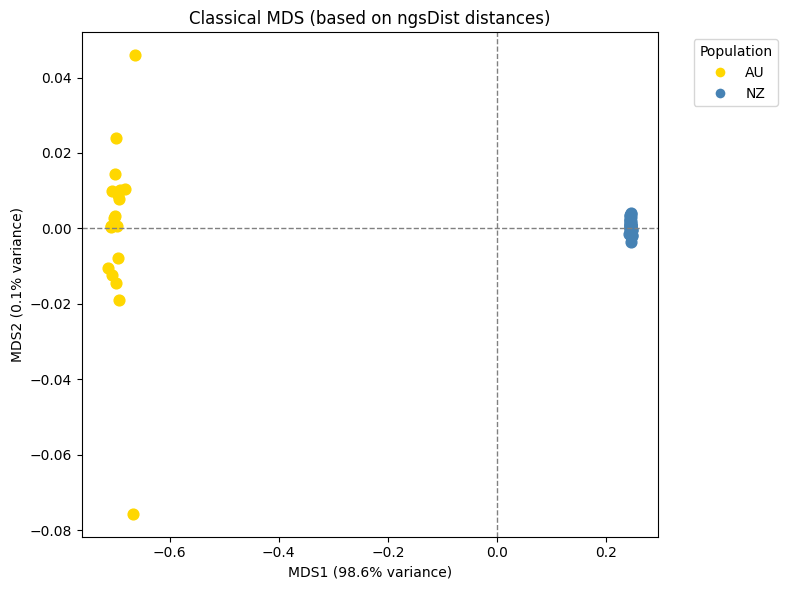

In [28]:
ngsdist_file = "angsd/neutral/structure/GLOBAL_dist"
popmap_file = "angsd/pop_map"
custom_colors = {
    "AU": "gold",
    "NZ": "steelblue"
    # Add your populations and colors
}

sample_names, distance_matrix = read_ngsdist(ngsdist_file)
population_map = load_population_map(popmap_file)

coords, var_percents = classical_mds(distance_matrix, n_components=5)

# Print all 5 axes' variance
print("Variance explained per MDS axis:")
for i, v in enumerate(var_percents):
    print(f"  Axis {i+1}: {v:.2f}%")

# Plot first two
plot_classical_mds(coords, sample_names, population_map, var_percents, custom_colors)

Variance explained per MDS axis:
  Axis 1: 96.30%
  Axis 2: 0.24%
  Axis 3: 0.22%
  Axis 4: 0.20%
  Axis 5: 0.20%


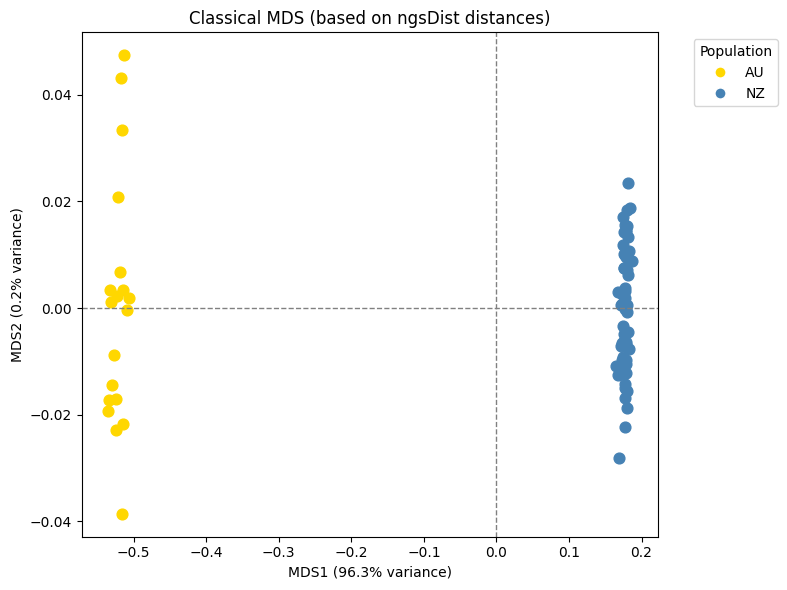

In [29]:
ngsdist_file = "smoove/structure/GLOBAL_dist"
popmap_file = "smoove/pop_map"
custom_colors = {
    "AU": "gold",
    "NZ": "steelblue"
    # Add your populations and colors
}

sample_names, distance_matrix = read_ngsdist(ngsdist_file)
population_map = load_population_map(popmap_file)

coords, var_percents = classical_mds(distance_matrix, n_components=5)

# Print all 5 axes' variance
print("Variance explained per MDS axis:")
for i, v in enumerate(var_percents):
    print(f"  Axis {i+1}: {v:.2f}%")

# Plot first two
plot_classical_mds(coords, sample_names, population_map, var_percents, custom_colors)

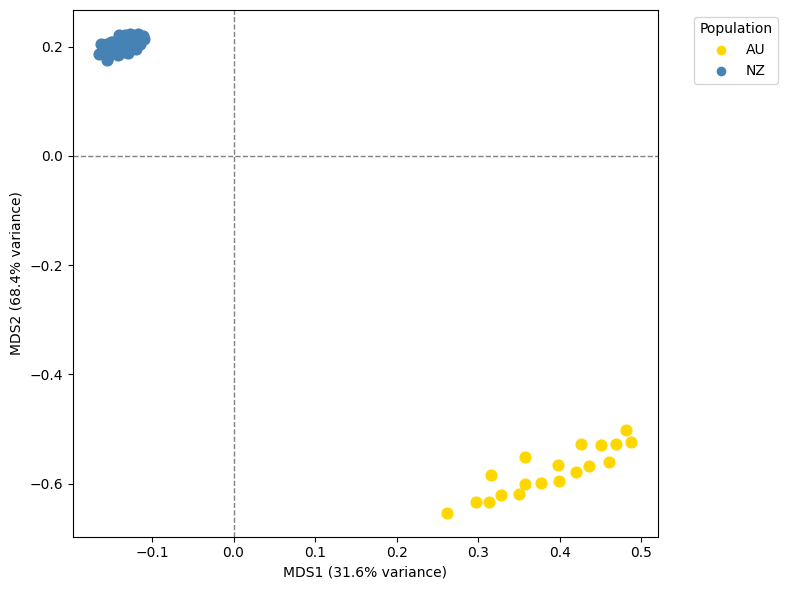

In [23]:
custom_colors = {
    "AU": "gold",
    "NZ": "steelblue"
}

# Load sample names and distance matrix
sample_names, distance_matrix = read_ngsdist("angsd/neutral/structure/GLOBAL_dist")

# Load population mapping
population_map = load_population_map("angsd/pop_map")  # change delimiter if needed

# Plot
plot_mds(sample_names, distance_matrix, population_map, custom_colors)

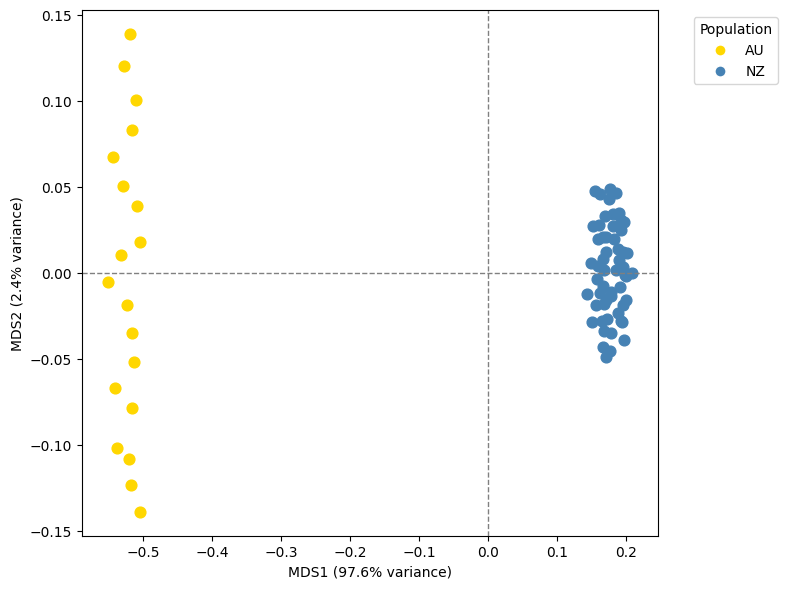

In [20]:
custom_colors = {
    "AU": "gold",  # blue
    "NZ": "steelblue"
}

# Load sample names and distance matrix
sample_names, distance_matrix = read_ngsdist("smoove/structure/GLOBAL_dist")

# Load population mapping
population_map = load_population_map("smoove/pop_map")  # change delimiter if needed

# Plot
plot_mds(sample_names, distance_matrix, population_map, custom_colors)

In [7]:
import pandas as pd
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import os
path = '/nesi/nobackup/uc03718/'
os.chdir(path)
print(os.getcwd())

# Read distance matrix
dist_matrix = pd.read_csv("smoove/structure/GLOBAL_dist", sep="\t", index_col=0)

# Perform MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coords = mds.fit_transform(dist_matrix)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(mds_coords[:, 0], mds_coords[:, 1])
for i, label in enumerate(dist_matrix.index):
    plt.annotate(label, (mds_coords[i, 0], mds_coords[i, 1]))
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.show()

/nesi/nobackup/uc03718


ParserError: Could not construct index. Requested to use 1 number of columns, but 75 left to parse.

In [ ]:
mds = pd.read_csv('angsd/structureS/GLOBAL_neutral.mds', sep='\t')
svmds = pd.read_csv('graphtyper/fairy_mds/GLOBAL_sv.mds', sep='\t')
pops = pd.read_csv('angsd/structure_MDS/mds_pops.tsv', sep='\t', header=None)

color = ['gold'] * 19 + ['steelblue'] * 54

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False, sharey=False)

axes[0].scatter(mds['D1_97.5736950999342'], mds['D2_0.142602294031928'], c=color)
axes[0].axvline(x=sum(mds['D1_97.5736950999342']) / len(mds['D1_97.5736950999342']), color='grey', linewidth=0.25)
axes[0].axhline(y=sum(mds['D2_0.142602294031928']) / len(mds['D2_0.142602294031928']), color='grey', linewidth=0.25)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('Dimension 1 (97.6%)', fontsize=18)
axes[0].set_ylabel('Dimension 2 (0.14%)', fontsize=18)
axes[0].set_title('A)', fontsize=20, loc='left')

axes[1].scatter(svmds['D1_89.9822458572729'], svmds['D2_0.646326592188632'], c=color)
axes[1].axvline(x=sum(svmds['D1_89.9822458572729']) / len(svmds['D1_89.9822458572729']), color='grey', linewidth=0.25)
axes[1].axhline(y=sum(svmds['D2_0.646326592188632']) / len(svmds['D2_0.646326592188632']), color='grey', linewidth=0.25)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel('Dimension 1 (89.98%)', fontsize = 18)
axes[1].set_ylabel('Dimension 2 (0.65%)', fontsize = 18)
axes[1].set_title('B)', fontsize=20, loc='left')

plt.savefig('plots/GLOBAL_MDS.png', dpi=300, bbox_inches='tight')

## Estimating Nucleotide Diversity (π)
We estimated nucleotide diversity (π) for the West Australian population of fairy tern and tara iti independently, using the site frequency spectrum (SFS) estimated above as a prior.  

In [ ]:

for POP in AU TI KI
    do
    if [[ "$POP" == "AU" ]]
        then
        angsd -P 26 -b ${ANGSD}${POP}.list -ref $REF -anc $ANC -sites $SITES -out ${ANGSD}${TOOL}diversity/${POP}_pest \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 19 -setMinDepth 200 -setMaxDepth 420 -doCounts 1 \
            -GL 1 -doSaf 1 -pest ${ANGSD}${TOOL}/sfs/${POP}.sfs
        realSFS -p 40 -anc ${ANC} -ref ${REF} ${ANGSD}${TOOL}diversity/${POP}_pest.saf.idx > ${ANGSD}${TOOL}diversity/${POP}_pest.sfs
        realSFS saf2theta ${ANGSD}${TOOL}/diversity/${POP}_pest.saf.idx -sfs ${ANGSD}${TOOL}diversity/${POP}_pest.sfs -outname ${ANGSD}${TOOL}/diversity/${POP}_pest
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -win 10000 -step 1000 -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_thetas_10KBwindows_1KBstep
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -win 50000 -step 10000 -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_thetas_50KBwindows_10KBstep
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_all_Thetas
    elif [[ "$POP" == "TI" ]]
        then
        angsd -P 26 -b ${ANGSD}${POP}.list -ref $REF -anc $ANC -sites $SITES -out ${ANGSD}${TOOL}diversity/${POP}_pest \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 15 -setMinDepth 120 -setMaxDepth 280 -doCounts 1 \
            -GL 1 -doSaf 1 -pest ${ANGSD}${TOOL}/sfs/${POP}.sfs
        realSFS -p 40 -anc ${ANC} -ref ${REF} ${ANGSD}${TOOL}diversity/${POP}_pest.saf.idx > ${ANGSD}${TOOL}diversity/${POP}_pest.sfs
        realSFS saf2theta ${ANGSD}${TOOL}/diversity/${POP}_pest.saf.idx -sfs ${ANGSD}${TOOL}diversity/${POP}_pest.sfs -outname ${ANGSD}${TOOL}/diversity/${POP}_pest
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -win 10000 -step 1000 -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_thetas_10KBwindows_1KBstep
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -win 50000 -step 10000 -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_thetas_50KBwindows_10KBstep
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_all_Thetas
    else
        angsd -P 26 -b ${ANGSD}${POP}.list -ref $REF -anc $ANC -sites $SITES -out ${ANGSD}${TOOL}diversity/${POP}_pest \
            -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 \
            -minMapQ 20 -minQ 20 -minInd 24 -setMinDepth 700 -setMaxDepth 1200 -doCounts 1 \
            -GL 1 -doSaf 1 -pest ${ANGSD}${TOOL}/sfs/${POP}.sfs
        realSFS -p 40 -anc ${ANC} -ref ${REF} ${ANGSD}${TOOL}diversity/${POP}_pest.saf.idx > ${ANGSD}${TOOL}diversity/${POP}_pest.sfs
        realSFS saf2theta ${ANGSD}${TOOL}/diversity/${POP}_pest.saf.idx -sfs ${ANGSD}${TOOL}diversity/${POP}_pest.sfs -outname ${ANGSD}${TOOL}/diversity/${POP}_pest
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -win 10000 -step 1000 -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_thetas_10KBwindows_1KBstep
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -win 50000 -step 10000 -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_thetas_50KBwindows_10KBstep
        thetaStat do_stat ${ANGSD}${TOOL}/diversity/${POP}_pest.thetas.idx -outnames ${ANGSD}${TOOL}diversity/${POP}_pest_all_Thetas
done

## Estimating D<sub>XY</sub>
When aiming to estimate D<sub>XY</sub>, we need to first get a list of sites variable in each population. This is so sites that may be fixed in one population are included in our estimates.  

In [ ]:
angsd -P 24 -b ${ANGSD}AU.list -ref $TREF -anc $TANC -sites $TSITES -out ${ANGSD}neutral/diversity/AU_initialDxy \
    -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 -minMapQ 20 -minQ 20 \
    -minInd 19 -setMinDepth 200 -setMaxDepth 420 -doCounts 1 -doMajorMinor 1 \
    -GL 1 -doMaf 1 -skipTriallelic 1 -SNP_pval 1e-6

angsd -P 24 -b ${ANGSD}TI.list -ref $TREF -anc $TANC -sites $TSITES -out ${ANGSD}neutral/diversity/TI_initialDxy \
    -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 -minMapQ 20 -minQ 20 \
    -minInd 15 -setMinDepth 120 -setMaxDepth 280 -doCounts 1 -doMajorMinor 1 \
    -GL 1 -doMaf 1 -skipTriallelic 1 -SNP_pval 1e-6

angsd -P 24 -b ${ANGSD}AU.list -ref $TREF -anc $TANC -out ${ANGSD}samtools/diversity/AU_initialDxy \
    -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 -minMapQ 20 -minQ 20 \
    -minInd 19 -setMinDepth 200 -setMaxDepth 420 -doCounts 1 -doMajorMinor 1 \
    -GL 1 -doMaf 1 -skipTriallelic 1 -SNP_pval 1e-6

angsd -P 24 -b ${ANGSD}TI.list -ref $TREF -anc $TANC -out ${ANGSD}samtools/diversity/TI_initialDxy \
    -uniqueOnly 1 -remove_bads 1 -only_proper_pairs 1 -trim 0 -C 50 -baq 1 -minMapQ 20 -minQ 20 \
    -minInd 15 -setMinDepth 120 -setMaxDepth 280 -doCounts 1 -doMajorMinor 1 \
    -GL 1 -doMaf 1 -skipTriallelic 1 -SNP_pval 1e-6

We then extracted the chromosome and position from each population and merge them into a sites file.  

In [ ]:
zcat ${ANGSD}neutral/diversity/{AU,TI}_initialDxy.mafs.gz | awk '{print $1"\t"$2}' | grep -v "chromo" | sort -k1,1 -k2,2n | uniq > ${ANGSD}neutral_Dxy_sites.bed
zcat ${ANGSD}samtools/diversity/*_initialDxy.mafs.gz | awk '{print $1"\t"$2}' | grep -v "chromo" | sort -k1,1 -k2,2n | uniq > ${ANGSD}whole-genome_Dxy_sites.bed

angsd sites index neutral_Dxy_sites.bed
angsd sites index whole-genome_Dxy_sites.bed

And finally estimated allele frequency estimates at these overlapping sites.  

In [ ]:
for POP in AU TI
    do
    angsd -P 26 -b ${ANGSD}${POP}.list -ref $REF -anc $ANC -sites ${ANGSD}neutral_DXYsites.bed \
        -out ${ANGSD}neutral/diversity/${POP}_anc_DXY -GL 1 -doMajorMinor 5 -doMaf 1
    angsd -P 26 -b ${ANGSD}${POP}.list -ref $REF -sites ${ANGSD}neutral_DXYsites.bed \
        -out ${ANGSD}neutral/diversity/${POP}_ref_DXY -GL 1 -doMajorMinor 4 -doMaf 1
    angsd -P 26 -b ${ANGSD}${POP}.list -ref $REF -anc $ANC -sites ${ANGSD}whole-genome_DXYsites.bed \
        -out ${ANGSD}samtools/diversity/${POP}_anc_DXY -GL 1 -doMajorMinor 5 -doMaf 1
    angsd -P 26 -b ${ANGSD}${POP}.list -ref $REF -sites ${ANGSD}whole-genome_DXYsites.bed \
        -out ${ANGSD}samtools/diversity/${POP}_ref_DXY -GL 1 -doMajorMinor 4 -doMaf 1
done

And finally we adapted a Rscript by Joshua Penalba [here](https://github.com/mfumagalli/ngsPopGen/blob/master/scripts/calcDxy.R) to calculate DXY using the allele frequencies in each respective population's MAF file.